SAS & HSE, Applied Time Series Forecasitng , Fall 2021 

<font color="blue"> Lesson #3: Holt, Winters, Theil-Wage models. Exponential Smoothing Models </font>

<span style="color:black; font-size: 12pt"></span>

Alexey Romanenko,
<font color="blue">alexromsput@gmail.com</font>

**Key words:**  exponential smoothing models, Holt model,Winters model, Theil-Wage Model

**Your fitback:**  please provide you feedback  <a href="https://forms.gle/bEV5iwmTqdM9rUoy8"> here </a>

In [ ]:
import numpy as np
from datetime import datetime, timedelta
import pylab
import matplotlib.pyplot as plt
import pandas as pd
import math
import pandas.tseries.offsets as ofs

from utils import qualityMAPE, SimpleExponentialSmoothing
# from utils import plot_ts_forecast, plot_ts_forecast # don't forget to upload file in colab working repository
# import warnings as w
# from matplotlib import gridspec
# import plotly.plotly as py
# import seaborn as sns

from IPython.display import Image

%matplotlib inline

In [92]:
def build_forecast(h, ts, alg_name, alg_title, params_array, step='D'):
    
  FRC_TS = dict()

  for p in params_array:
      frc_horizon = pd.date_range(ts.index[-1], periods=h+1, freq=step)[1:]
      frc_ts = pd.DataFrame(index = ts.index.append(frc_horizon), columns = ts.columns)
      
      for cntr in ts.columns:
          frc_ts[cntr] = eval(alg_name)(ts[cntr], h, p)
     
#         frc_ts.columns = frc_ts.columns+('%s %s' % (alg_title, p))
      FRC_TS['%s %s' % (alg_title, p)] = frc_ts
  
  return FRC_TS

def plot_ts_forecast(ts, frc_ts, ts_num=0, alg_title=''):
  frc_ts.columns = ts.columns+'; '+alg_title
  ts[ts.columns[ts_num]].plot(style='b', linewidth=1.0, marker='o')
  ax = frc_ts[frc_ts.columns[ts_num]].plot(style='r-^', figsize=(25,5), linewidth=1.0)
  plt.xlabel("Time ticks")
  plt.ylabel("TS values")
  plt.legend()
  return ax

# Holt model, Winters Model, Theil-Wage Model

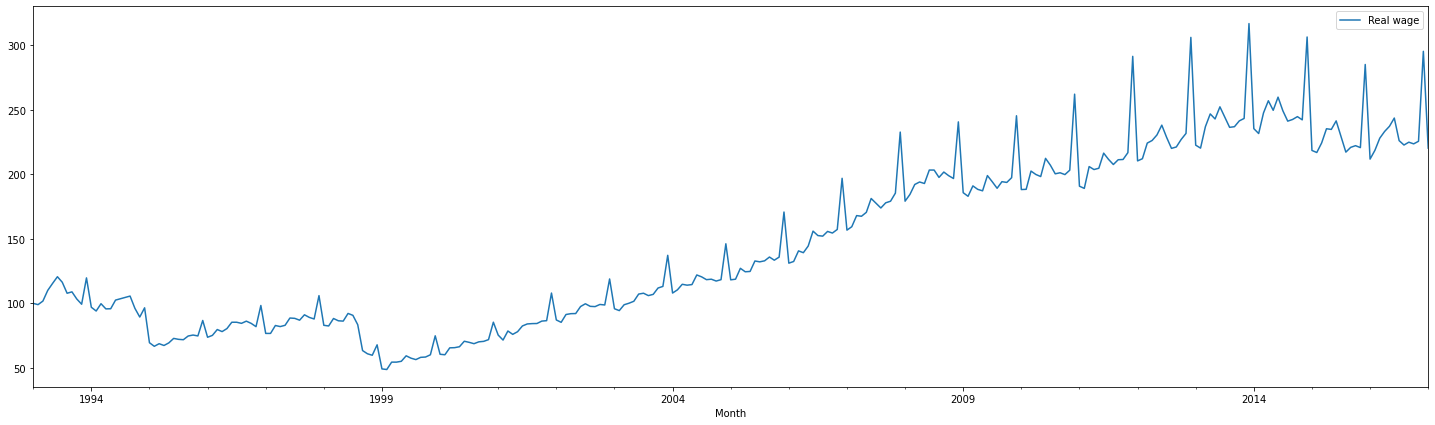

In [ ]:
# Wage data in RF
wage = pd.read_csv('https://raw.githubusercontent.com/aromanenko/ATSF/main/data/monthly-wage.csv', sep=';', index_col= 0, parse_dates=True)
wage.plot(figsize=(25,7))

**Question:**
   * Which hidden components of the ts are not considered by SES?

## Holt Model

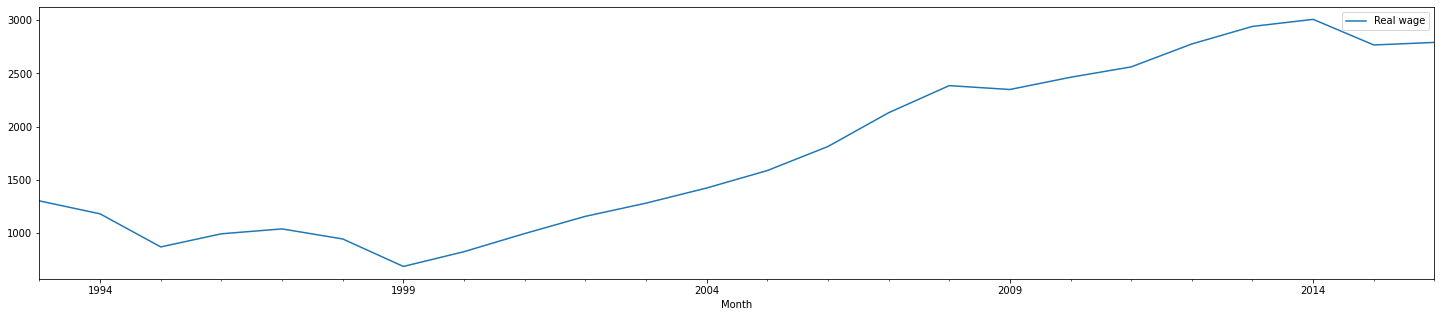

In [ ]:
# Aggregate original TS by Years
wage_year = wage.resample("12MS").sum()[:-1] # cut 2017 year
wage_year.plot(figsize=(25,5))

In [ ]:
ESparams_array

[{'alpha': 0.01},
 {'alpha': 0.12},
 {'alpha': 0.23},
 {'alpha': 0.34},
 {'alpha': 0.45},
 {'alpha': 0.56},
 {'alpha': 0.67},
 {'alpha': 0.78},
 {'alpha': 0.89},
 {'alpha': 1.0}]

MAPE: Real wage    0.088797
dtype: float64


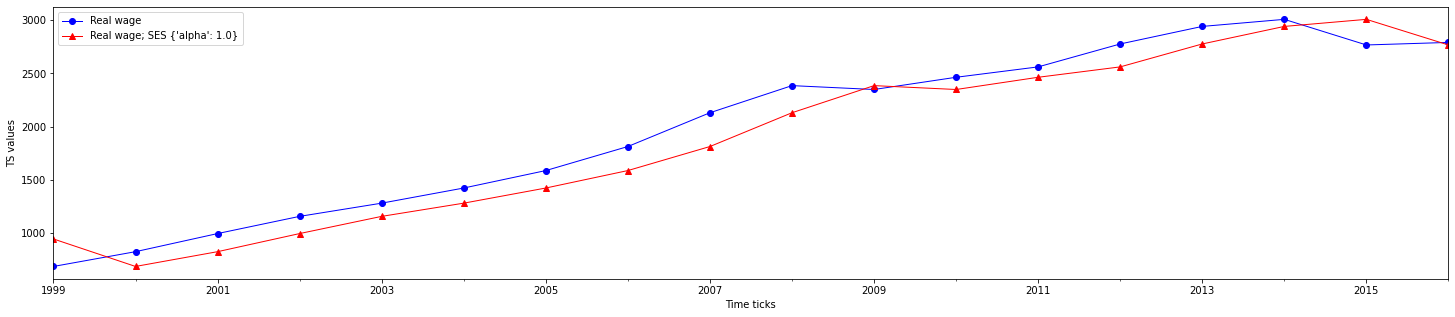

In [ ]:
# SES Forecast for monthly agregated data
ALPHA = np.linspace(0.01,1,10)
ESparams_array = [{'alpha':alpha} for alpha in ALPHA]
FRC_WAGE_YEAR = build_forecast(h=1, ts=wage_year, alg_name =  'SimpleExponentialSmoothing', alg_title='SES'
                              ,params_array = ESparams_array, step='12MS')

# forecast accuracy 
QualityStr = pd.DataFrame(index = wage_year.columns, columns = FRC_WAGE_YEAR.keys())

ix = wage_year.loc['2010-01':'2018-01'].index
for param_cntr in sorted(QualityStr.columns):
    frc_wage = FRC_WAGE_YEAR[param_cntr]
    QualityStr[param_cntr],_ = qualityMAPE(wage_year.loc[ix], frc_wage.loc[ix])

# Draw forecast of the best SES algorithm
alg_name = QualityStr[QualityStr.columns].mean().sort_values().index[0]
plot_ts_forecast(wage_year.loc['1999-01-01':'2016-01-01'], FRC_WAGE_YEAR[alg_name].loc['1999-01-01':'2016-01-01']
               , ts_num=0, alg_title=alg_name)

test_period_start = '2000-01-01'
test_period_end = '2016-01-01'
print('MAPE: %s' % qualityMAPE(wage_year.loc[test_period_start:test_period_end], FRC_WAGE_YEAR[alg_name].loc[test_period_start:test_period_end])[0])


**Question:**
   * How to include trend component in Exponential Smoothing model?

**From Simple Exponential Smoothing to Holt Model**
$\varepsilon_t~-$ error component (unobserved noise)

$l_t$ $-$ changing slowly level of time series,

$\hat l_t~-$ an estimation of level

$\hat y_t~-$ forecast value for $y_t$ (made with delay = 1) 

${e_t = y_t - \hat y_t }$

<table border="0">
 <tr>
    <td><b style="font-size:30px">$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$Simple Exponential Smoothing$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$
</b></td>
    <td><b style="font-size:30px">$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$ Holt model (additive linear trend)$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$</b></td>
 </tr>
 <tr>
    <td>

Time Series Model    
    $$y_{t} = l_t + \color{red}{\varepsilon_t},$$

Forecasting model:

$$ {\hat y_{t+d}} = \color{\red}{\hat l_t} $$


$$\hat{l}_{t} = \alpha\cdot y_t+ (1-\alpha)\cdot \hat{y}_t = \hat y_t + \alpha \cdot \color{red}{e_t}$$
    <td>

Time series model:
$$  y_{t} = l_t + \color{red}{b_t}  + {\varepsilon_t} $$

Forecasting formula:
    $$  \hat y_{t+d} = l_t + \color{red}{b_t} d $$
    <!-- where $l_t$, $\color{red}{b_t}$ --- estimations of unopbserved components of level and trend correspondently -->


$$        l_t = \alpha y_t + (1-\alpha) (l_{t-1} + b_{t-1} ) = \color{red}{\hat y_{t} + \alpha e_t}$$ 

$$b_t = \beta (l_{t} - l_{t-1} ) + (1-\beta) b_{t-1} = \color{red}{b_{t-1}+ \alpha\beta e_t}.$$</td>
 </tr>
</table>



<!-- Доказательство 

$$\beta (l_{t} - l_{t-1} ) + (1-\beta) b_{t-1} = b_{t-1}+ \beta(l_t-l_{t-1}-b_{t-1})= b_{t-1}+ \beta(l_t-l_{t-1}-b_{t-1}) +\alpha e_t$$ -->



In [ ]:
###################### Holt Exponential Smoothing #########################
# x <array Tx1>- time series, 
# h <scalar> - forecasting delay
# Params <dict> - dictionary with 
#    alpha <scalar in [0,1]> - smoothing parameter
#    beta <scalar in [0,1]> - linear trend smoothing parameter
#    
def HoltExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    beta = Params['beta']
    AdaptationPeriod = Params['AdaptationPeriod']
    
    FORECAST = [np.NaN]*(T+h)
    if alpha>1:
        w.warn('Alpha can not be more than 1')
        #alpha = 1
        return FORECAST
    if alpha<0:
        w.warn('Alpha can not be less than 0')
        #alpha = 0
        return FORECAST
    if beta>1:
        w.warn('beta can not be more than 1')
        #beta = 1
        return FORECAST
    if beta<0:
        w.warn('beta can not be less than 0')
        #beta = 0
        return FORECAST
    
    
    l= np.NaN
    b= np.NaN
    
    for t in range(T):
        if not math.isnan(x[t]):
            if math.isnan(l):
                l = x[t]
                b = x[t+1]-x[t]
                t0 = np.NaN
                
            l_prev = l    
                        
            if (t-t0+1)<AdaptationPeriod:
                l = (1-(1-alpha)*(t-t0+1)/(AdaptationPeriod))* x[t] + (1-alpha)*(t-t0+1)/(AdaptationPeriod)*(l+b)
                b = (1-beta)*(t-t0+1)/(AdaptationPeriod)*(l - l_prev) + (1-alpha)*(t-t0+1)/(AdaptationPeriod)*b
            else:
                l = alpha* x[t] + (1-alpha)*(l+b)
                b = beta* (l - l_prev) + (1- beta)*b
                # b = beta* (x[t] - l_prev) + (1- beta)*b


        FORECAST[t+h] = l+ b*h
    return FORECAST

MAPE: Real wage    0.071716
dtype: float64


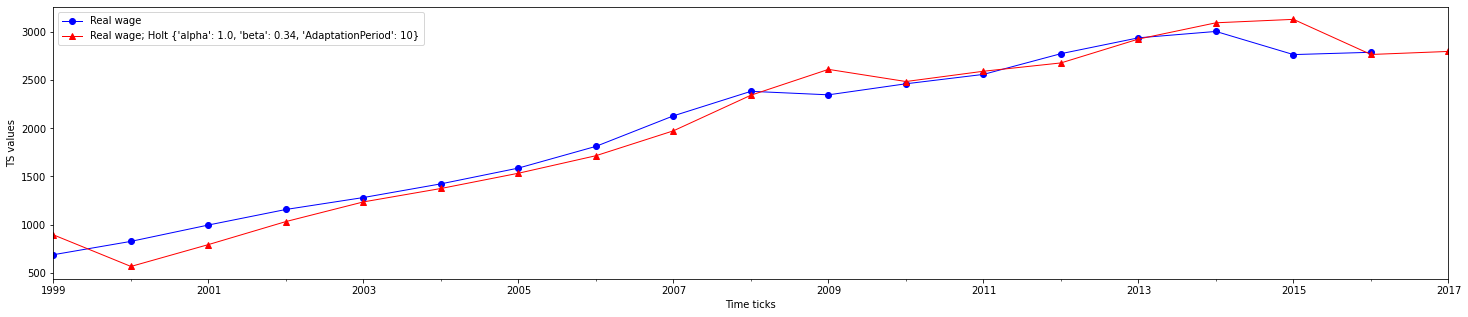

In [ ]:
# SES Forecast for monthly agregated data
ALPHA = np.linspace(0.01,1,10)
BETA = np.linspace(0.01,1,10)

holt_params_array = [{'alpha':alpha, 'beta':beta, 'AdaptationPeriod':10} for alpha in ALPHA for beta in BETA]
FRC_WAGE_YEAR = build_forecast(h=1, ts=wage_year, alg_name =  'HoltExponentialSmoothing', alg_title='Holt'
                              ,params_array = holt_params_array, step='12MS')

# # forecast accuracy 
QualityStr = pd.DataFrame(index = wage_year.columns, columns = FRC_WAGE_YEAR.keys())

ix = wage_year.loc['2010-01':'2018-01'].index
for param_cntr in sorted(QualityStr.columns):
    frc_wage = FRC_WAGE_YEAR[param_cntr]
    QualityStr[param_cntr],_ = qualityMAPE(wage_year.loc[ix], frc_wage.loc[ix])

# # Draw forecast of the best SES algorithm
alg_name = QualityStr[QualityStr.columns].mean().sort_values().index[0]
plot_ts_forecast(wage_year.loc['1999-01-01':'2018-01-01'], FRC_WAGE_YEAR[alg_name].loc['1999-01-01':'2018-01-01']
               , ts_num=0, alg_title=alg_name)

print('MAPE: %s' % qualityMAPE(wage_year.loc[test_period_start:test_period_end], FRC_WAGE_YEAR[alg_name].loc[test_period_start:test_period_end])[0])

## Winters Model

In [ ]:
ts = pd.read_csv('https://raw.githubusercontent.com/aromanenko/ATSF/main/data/seasonal_ts.csv', parse_dates=['Dates'], sep=';', dayfirst=True, index_col='Dates')
ts.index.names=['Timestamp']
ts = ts.sort_index() # sort index
ts.head()

,Item1,Item2,Item3,Item4,Item5,Item6,Item7,Item8,Item9,Item10
Timestamp,,,,,,,,,,
2006-01-01,0,49,64,70.468,0,45.182,71,21.664,138,0
2006-01-02,0,56,60,57.368,0,39.506,27,19.664,76,6
2006-01-03,0,61,71,34.350,0,28.064,10,10.402,152,12
2006-01-04,0,32,59,40.186,0,40.256,27,9.938,67,12
2006-01-05,0,45,61,28.914,0,35.784,27,16.672,49,24


In [ ]:
# Interval of ts 
ts.loc['2007-01-01':'2007-01-05']

,Item1,Item2,Item3,Item4,Item5,Item6,Item7,Item8,Item9,Item10
Timestamp,,,,,,,,,,
2007-01-01,156,135,64,95.925,68,57.934,30,28.854,19,0
2007-01-02,138,117,62,43.775,63,52.693,19,24.478,14,18
2007-01-03,148,98,67,50.750,57,43.406,15,15.704,18,6
2007-01-04,147,86,67,54.020,47,53.018,9,21.846,15,6
2007-01-05,146,124,71,50.400,59,74.212,15,33.082,2,12


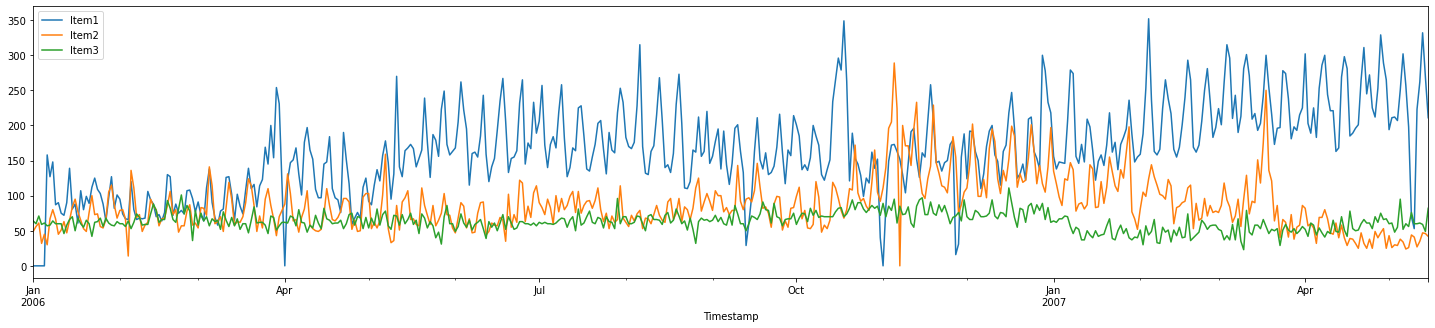

In [ ]:
# fig = plt.figure()
ts.loc['2005-07-01':'2007-12-31', ts.columns[range(3)]].plot(figsize=(25,5))
# to save the pictures
# plt.savefig('../Lecture_TS_Forecasting/pic/TS_Example.eps', bbox_inches='tight', pad_inches=0, format='eps', dpi=1000) 

**Questions**

 - What are key aspects of these retail ts?
 - How to change SES model to consider seasonlaity in original data?

**Additive Winters Model = Additive Seasonality**

Time Series model
$$y_t = l_t + s_{t}+\varepsilon_t$$
where $s_t$ - is a seasonla component of period $p$

Forecasting Model
$$\hat{y}_{t+d} = l_t +  s_{t+d}; \\
		l_{t}       	=  \alpha \left(y_t - s_{t-p}\right)+ \left(1-\alpha\right) \left(l_{t-1}\right)=\color{red}{l_{t-1} + \alpha e_t}; \\
		s_t         	= \gamma\left(y_t-l_{t-1}\right) + \left(1-\gamma\right)s_{t-p} = \color{red}{s_{t-p} + \gamma(1-\alpha)e_t}.
		$$

In [ ]:

###################### Additive Winters Exponential Smoothing #########################
# x <array Tx1>- time series, 
# h <scalar> - forecasting delay
# Params <dict> - dictionary with 
#    alpha <scalar in [0,1]> - level smoothing parameter
#    gamma <scalar in [0,1]> - seasonality smoothing parameter

def AdditiveWintersExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    gamma = Params['gamma']
    p = Params['seasonality_period']
    
    FORECAST = [np.NaN]*(T+h)
    
    l= np.NaN
    s= []
    
    for cntr in range(T):
        if not math.isnan(x[cntr]):
            if math.isnan(l):
                l= x[cntr]
            if len(s)==0:
                # looking in the future
                for i in range(p):
                    s.append(x[i])
            if cntr<p:
                l = alpha*(x[cntr]-s[cntr])+(1-alpha)*l # recurrent smoothing of level 
            else:
                s.append(gamma*(x[cntr]-l)+(1-gamma)*s[cntr-p])
                l = alpha*(x[cntr]-s[cntr-p])+(1-alpha)*l # recurrent smoothing of level 
                
        FORECAST[cntr+h] = l + s[cntr+h-(1+h//p)*p]
    return FORECAST


In [ ]:
QualityStr.loc[QualityStr.index[8]].sort_values().index[0]

"AWinters {'alpha': 0.12, 'gamma': 0.45, 'seasonality_period': 7}"

MAPE: Item1     0.134413
Item2     0.266263
Item3     0.181491
Item4     0.168252
Item5     0.221856
Item6     0.272372
Item7     0.332370
Item8     0.304125
Item9     0.866929
Item10    0.679796
dtype: float64


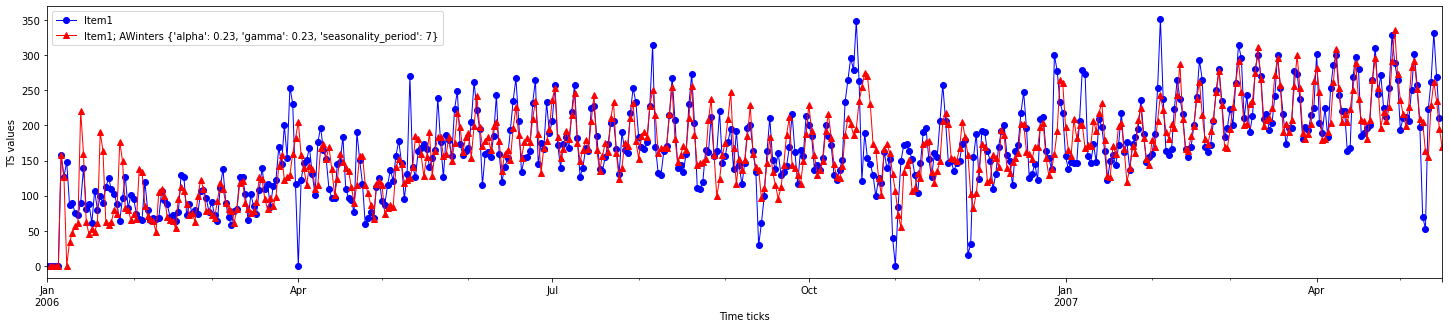

In [ ]:
# SES Forecast for monthly agregated data
ALPHA = np.linspace(0.01,1,10)
GAMMA = np.linspace(0.01,1,10)

wint_params_array = [{'alpha':alpha, 'gamma':gamma, 'seasonality_period':7} for alpha in ALPHA for gamma in GAMMA]
FRC_SEAS_TS = build_forecast(h=1, ts=ts, alg_name =  'AdditiveWintersExponentialSmoothing', alg_title='AWinters'\
                              ,params_array = wint_params_array, step='D')

# # forecast accuracy 
QualityStr = pd.DataFrame(index = ts.columns, columns = FRC_SEAS_TS.keys())

ix = ts.loc['2006-01-01':'2007-01-01'].index
for param_cntr in sorted(QualityStr.columns):
    frc_wage = FRC_SEAS_TS[param_cntr]
    QualityStr[param_cntr],_ = qualityMAPE(ts.loc[ix], frc_wage.loc[ix])

# # Draw forecast of the best algorithm (mean on all ts)
alg_name = QualityStr[QualityStr.columns].mean().sort_values().index[0]
plot_ts_forecast(ts.loc[:], FRC_SEAS_TS[alg_name].loc[:]
               , ts_num=0, alg_title=alg_name)

test_period_start = '2007-01-01'
test_period_end = '2007-06-01'
print('MAPE: %s' % qualityMAPE(ts.loc[test_period_start:test_period_end], FRC_SEAS_TS[alg_name].loc[test_period_start:test_period_end])[0])

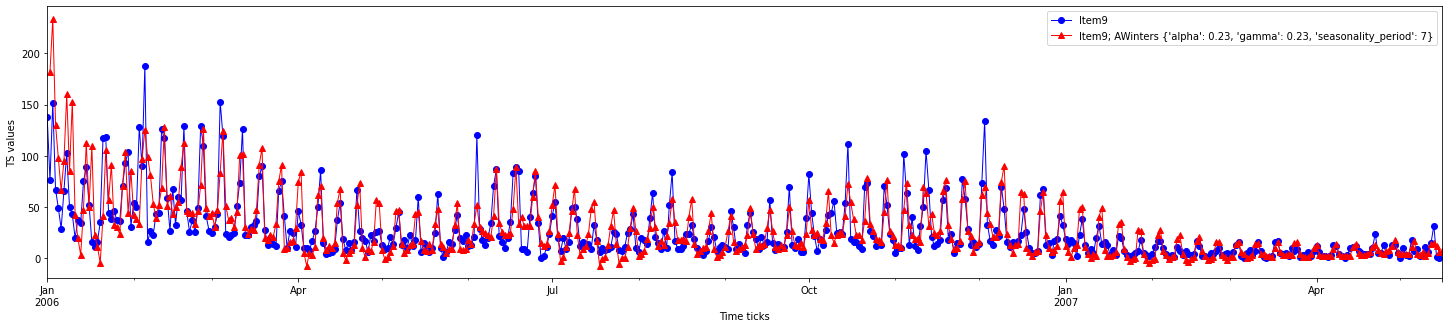

In [ ]:
plot_ts_forecast(ts.loc['1999-01-01':'2018-01-01'], FRC_SEAS_TS[alg_name].loc['1999-01-01':'2018-01-01']
               , ts_num=8, alg_title=alg_name)

**Questions** 
  - Why Additive Winters model forecast is inadequate for this TS?
  - Deas we select the best paramters of the AWinters model for this ts?

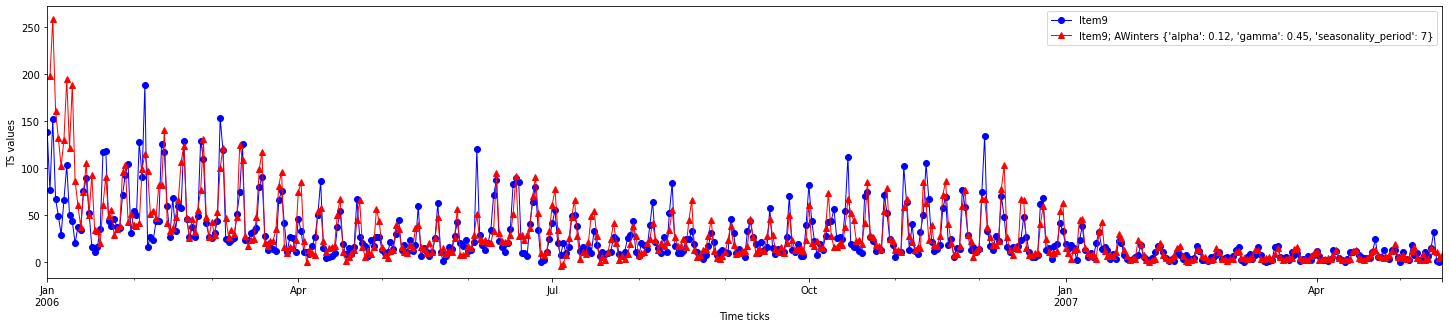

In [ ]:
# the best algorithm for Item9
alg_name = QualityStr.loc[QualityStr.index[8]].sort_values().index[0]
plot_ts_forecast(ts, FRC_SEAS_TS[alg_name], ts_num=8, alg_title=alg_name)

## Theil-Wage Model

**Questions** 
  - How to consider both additive trend and additive seasonality?

Time Series Model:
$$ \hat y_{t+d} = (l_t + b_t d) + s_{t+d}. $$
$s_t$ - seasonal component of period $p$,

Forecasting Model
$$ l_t = \alpha (y_t - s_{t-p}) + (1-\alpha) (l_{t-1} + b_{t-1} )=\color{red}{l_{t-1} + b_{t-1} + \alpha e_t};$$

$$b_t = \beta (l_{t} - l_{t-1} ) + (1-\beta) b_{t-1} = \color{red}{b_{t-1} + \alpha\beta e_t};$$
$$ s_t =\gamma (y_t-l_t) + (1-\gamma) s_{t-p} = \color{red}{s_{t-p} + \gamma(1-\alpha)e_t}.$$

In [ ]:

###################### Winters Exponential Smoothing #########################
# x <array Tx1>- time series, 
# h <scalar> - forecasting delay
# Params <dict> - dictionary with 
#    alpha <scalar in [0,1]> - level smoothing parameter
#    beta <scalar in [0,1]> - trend smoothing parameter
#    gamma <scalar in [0,1]> - seasonality smoothing parameter

def TWExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    beta = Params['beta']
    gamma = Params['gamma']
    p = Params['seasonality_period']
    
    FORECAST = [np.NaN]*(T+h)
    
    l= np.NaN
    b=np.NaN
    s= []
    
    for cntr in range(T):
        if not math.isnan(x[cntr]):
            if math.isnan(l):
                l= x[cntr]
            if math.isnan(b):
                b= 0
            
            if len(s)==0:
                for i in range(p):
                    s.append(x[i])
                    
                    
            if cntr<p:
                l_old=l
                l = alpha*(x[cntr]-s[cntr])+(1-alpha)*(l+b)
                b=beta*(l-l_old)+(1-beta)*b
            else:
                l_old=l
                s.append(gamma*(x[cntr]-l)+(1-gamma)*s[cntr-p])
                l = alpha*(x[cntr]-s[cntr-p])+(1-alpha)*(l+b) # recurrent smoothing of level 
                b=beta*(l-l_old)+(1-beta)*b
            
        FORECAST[cntr+h] = l+b + s[cntr+h - (1+h//p)*p]
    return FORECAST

MAPE: Real wage    0.051961
dtype: float64


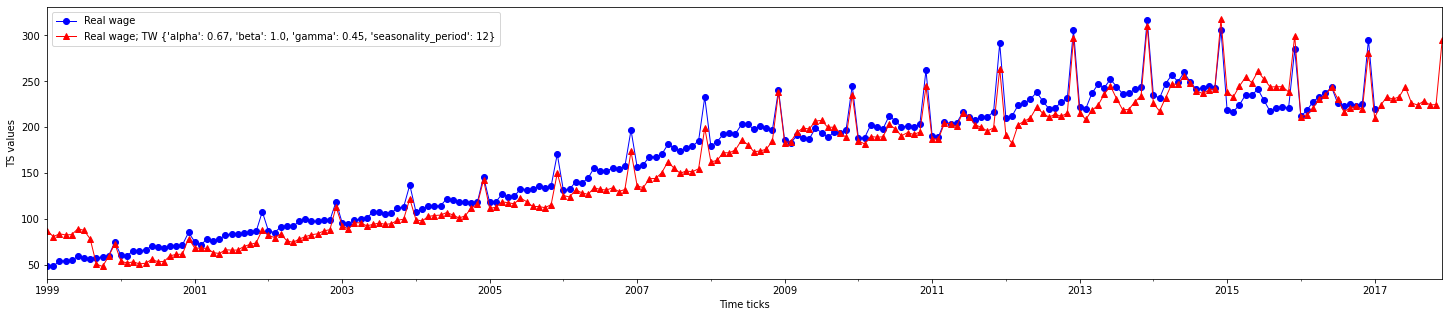

In [ ]:
# TW Forecast for monthly agregated data
ALPHA = np.linspace(0.01,1,10)
BETA = np.linspace(0.01,1,10)
GAMMA = np.linspace(0.01,1,10)

tw_params_array = [{'alpha':alpha, 'beta':beta, 'gamma':gamma, 'seasonality_period':12} for alpha in ALPHA for gamma in GAMMA for beta in BETA]
FRC_TREND_SEAS_TS = build_forecast(h=12, ts=wage, alg_name =  'TWExponentialSmoothing', alg_title='TW'\
                              ,params_array = tw_params_array, step='M')

# # forecast accuracy 
QualityStr = pd.DataFrame(index = wage.columns, columns = FRC_TREND_SEAS_TS.keys())

ix = wage.loc['2010-01':'2018-01'].index
for param_cntr in sorted(QualityStr.columns):
    frc = FRC_TREND_SEAS_TS[param_cntr]
    QualityStr[param_cntr],_ = qualityMAPE(wage.loc[ix], frc.loc[ix])

# # Draw forecast of the best SES algorithm
alg_name = QualityStr[QualityStr.columns].mean().sort_values().index[0]
plot_ts_forecast(wage.loc['1999-01-01':'2018-01-01'], FRC_TREND_SEAS_TS[alg_name].loc['1999-01-01':'2018-01-01']
               , ts_num=0, alg_title=alg_name)

test_period_start = '2015-01-01'
test_period_end = '2018-01-01'
print('MAPE: %s' % qualityMAPE(wage.loc[test_period_start:test_period_end], FRC_TREND_SEAS_TS[alg_name].loc[test_period_start:test_period_end])[0])

# Exponential Smoothing Models Family

In [80]:
datasets

<module 'sktime.datasets' from '/usr/local/lib/python3.7/dist-packages/sktime/datasets/__init__.py'>

In [79]:
from sktime import adatasets

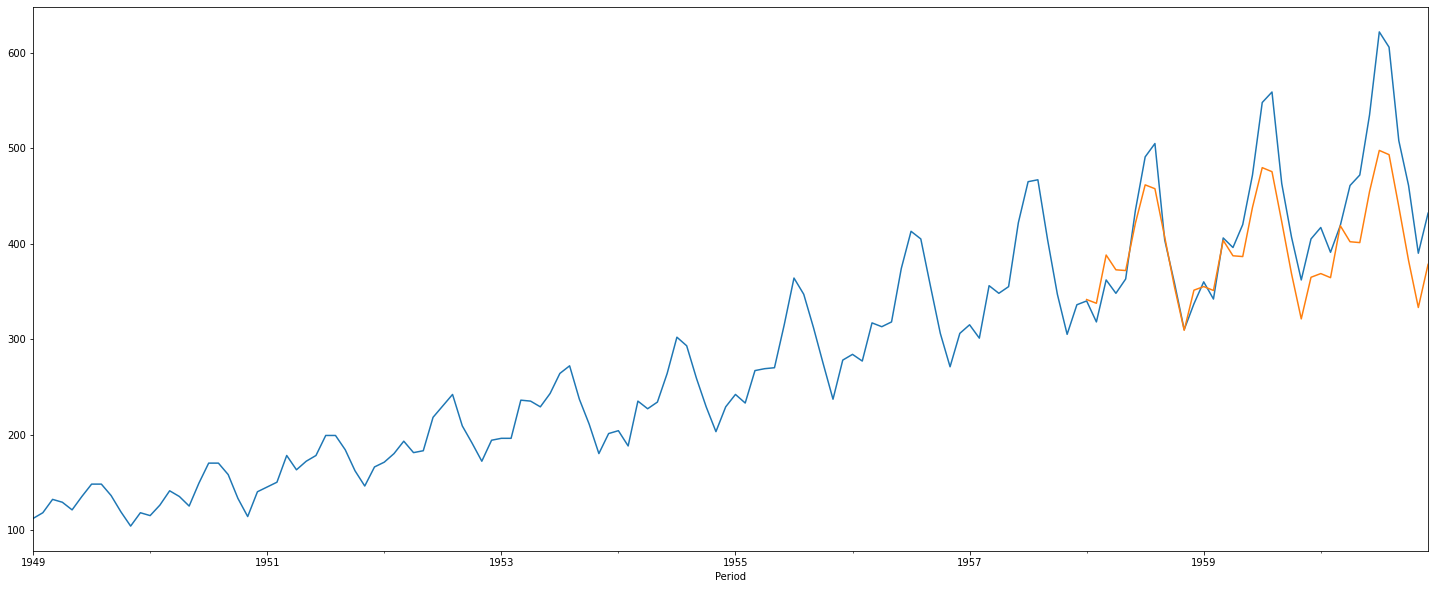

In [77]:
# use only for the first run:
# !pip install sktime 
from sktime.datasets import load_airline
# y = load_airline()
# y_train, y_test = temporal_train_test_split(y)
# fh = ForecastingHorizon(y_test.index, is_relative=False)
# forecaster = ThetaForecaster(sp=12)  # monthly seasonal periodicity
# forecaster.fit(y_train)
# y_pred = forecaster.predict(fh)
# mean_absolute_percentage_error(y_test, y_pred)
y.plot(figsize = (25,10))
y_pred.plot()


## Multiplicative trend model
**Multiplicative (exponential) trend:**
		$$
		\hat{y}_{t+d|t} = l_tb_t^d, \\
		l_{t}       = \alpha y_t + \left(1-\alpha\right) \left(l_{t-1} b_{t-1}\right), \\
		b_t         = \beta \frac{l_t}{l_{t-1}} + \left(1-\beta\right) b_{t-1}.
		$$
	
	



## Damp-trend model

**Additive damped trend**
		$$
		\hat{y}_{t+d|t} = l_t + \left(\phi + \phi^2 + \dots + \phi^{d}\right) b_t, \\
		l_{t}       = \alpha y_t + \left(1-\alpha\right) \left(l_{t-1} +\phi b_{t-1}\right), \\
		b_t         = \beta \left(l_t - l_{t-1}\right) + \left(1-\beta\right)\phi b_{t-1}.
		$$
		
		
**Multiplicative damped trend**
		$$
		\hat{y}_{t+d|t} = l_t b_t^{\left(\phi + \phi^2 + \dots + \phi^{d}\right)}, \\
		l_{t}       = \alpha y_t + \left(1-\alpha\right) l_{t-1} b_{t-1}^{\phi}, \\
		b_t         = \beta\frac{l_t}{l_{t-1}} + \left(1-\beta\right)b_{t-1}^{\phi}.
		$$


## Multiplicative Trend and Additive Seasonality
**Multiplicative seasonality of period $s$ with a linear trend**
    $$ \hat y_{t+d} = (l_t + b_t d) \cdot s_{t+d},$$
    
$$   l_t = \alpha (y_t / s_{t-p}) + (1-\alpha) (l_{t-1} + b_{t-1} ) = \color{red}{l_{t-1} + b_{t-1} + \alpha e_t/ s_{t-p}}; $$

$$  b_t = \beta (l_{t} - l_{t-1} ) + (1-\beta) b_{t-1} = \color{red}{b_{t-1}+ \alpha\beta e_t/s_{t-p}}; $$
$$s_t = \gamma (y_t/l_t) + (1-\gamma) s_{t-p} = \color{red}{s_{t-p} + \gamma (1-\alpha) e_t/l_t} .   $$

## Multiplicative Trend and Mupltiplicative Seasonlality
**Multiplicative (exponential) trend with Multiplicative seasonality**
    $$
        \hat y_{t+d} = l_t (b_t)^d \cdot s_{t + (d \bmod p) -p},
    $$
    $$
    l_t \mathop{=} \alpha (y_t / s_{t-p}) + (1-\alpha) l_{t-1} b_{t-1} = l_{t-1} b_{t-1} + \alpha e_t/s_{t-1};$$
        $$ b_t \mathop{=} \beta (l_{t} / l_{t-1} ) + (1-\beta) b_{t-1} = b_{t-1}+\alpha\beta e_t/s{t-1};$$
        $$
        s_t \mathop{=} \gamma (y_t/l_t) + (1-\gamma) s_{t-p} = s_{t-p} + \gamma(1-\alpha)e_t/l_{t}.
    $$


## Taxonomy of Time Series Models

 <table border="0">
 <tr>
    <td> 
     Trend\Seasonality
    </td>
    <td> 
       Seasonality N (None)
    </td>
    <td> 
       Seasonality A (Additive)
    </td>
    <td> 
       Seasonality M (Multiplicative)
    </td>
</tr>
 <tr>
    <td>
      Trend N (None)
    </td>
    <td>(N, N)</td>
    <td>(N, A)</td>
    <td>(N, M)</td>
 </tr>
 <tr>
    <td>
      Trend A (Additive)
    </td>
    <td>(A, N)</td>
    <td>(A, A)</td>
    <td>(A, M)</td>
 </tr>
 <tr>
    <td>
      Trend Ad (Additive damped)
    </td>
    <td>(Ad, N)</td>
    <td>(Ad, A)</td>
    <td>(Ad, M)</td>
 </tr>
 <tr>
    <td>
      Trend M (Multiplicative)
    </td>
    <td>(M, N)</td>
    <td>(M, A)</td>
    <td>(M, M)</td>
 </tr>
 <tr>
    <td>
      Trend Md (Multiplicative damped)
    </td>
    <td>(Md, N)</td>
    <td>(Md, A)</td>
    <td>(Md, M)</td>
 </tr>
</table>

## Pro&Cons Exponential Smoothing models
   PRO | Cons 
-------------------|------------------
Easy to Interpretate       | Initialization issues
Very fast, low computational time       |  Are not stable (retrain is needed) 
Can be applied to ts with missings       | Is not possible to inlcude causal variables


# HW1
see https://github.com/aromanenko/ATSF/blob/wip/HW1.ipynb

# Materials
* Лукишн Ю.П. Адаптивные методы краткосрочного прогнозирования временных рядов. Финансы и статистика. 2003, главы 1,4,5,7.
* https://otexts.com/fpp2/expsmooth.html